# 최고모델 찾기

In [33]:
import itertools
import pickle
import pathlib

##############################################
PETG_PKL_PATH = r"output\MODE2\ANN_2023_10_26_165137.pkl"  # PETG만 학습
TRANSFER_1_PKL_PATH = r"output\mode_a1\ANN_2023_10_26_184708.pkl"  # PETG만 학습
TRANSFER_2_PKL_PATH = r"output\mode_a2\ANN_2023_10_26_185846.pkl"  # PETG만 학습

N_BEST_MODELS = 5

PKL_FILE_PATH = TRANSFER_1_PKL_PATH
##############################################

def find_files_with_pattern(params):
    # 모든 순서 조합을 위한 패턴 생성
    patterns = [
        "".join([f"[{key.upper()}={value}]" for key, value in perm])
        for perm in itertools.permutations(params.items())
    ]

    # 현재 폴더에서 .keras로 끝나는 모든 파일을 검사
    folder = pathlib.Path(PKL_FILE_PATH).parent
    matched_files = set(
        str(file)
        for file in folder.glob("*.keras")
        for pattern in patterns
        if pattern in file.name
    )

    return list(matched_files)


with open(PKL_FILE_PATH, mode="rb") as f:
    pkl = pickle.load(f)


def extract_hyper_params_and_best_loss(data):
    hyper_params = data["train_input"]["hyper_params"]
    losses = data["train_output"]
    return hyper_params, min(losses["val_loss"])


hyper_params_and_losses = [
    extract_hyper_params_and_best_loss(data) for data in pkl
]
sorted_hyper_params_and_losses = sorted(
    hyper_params_and_losses, key=lambda x: x[1]
)
best_models = sorted_hyper_params_and_losses[:N_BEST_MODELS]
best_models = [
    find_files_with_pattern(hyper_params)
    for hyper_params, loss in best_models
    if len(find_files_with_pattern(hyper_params)) > 0
]
assert len(best_models) == N_BEST_MODELS, "모델을 찾을 수 없습니다."

for i, models in enumerate(best_models):
    print(f"=== {i+1}번째 모델 ===")
    for model in models:
        print(model)
    print()

best_model = best_models[0][0]
print(f"===>>> 최종 모델 <<<===")
print(best_model)

=== 1번째 모델 ===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.0][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras

=== 2번째 모델 ===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.01][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras

=== 3번째 모델 ===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.1][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras

=== 4번째 모델 ===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.25][L1_REG=0.0][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras

=== 5번째 모델 ===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.25][L1_REG=0.01][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras

===>>> 최종 모델 <<<===
output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.0][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras


# 데이터셋 및 모델 로딩

In [34]:
import keras
from training_ann import read_all_no_ss, ANNInputParams, ANNOutputParams

########## 여기에 데이터셋 종류를 넣어주세요. ##########
DATASET_TYPE = "petg_only"  # "abspla_only" or "petg_only"
#####################################################

# 불러올 모델 이름 정의
BASE_BEST = r"C:\Users\dcas\Documents\카카오톡 받은 파일\ANN_E8707[LR=0.005][N1=40][N2=30][N3=20].keras"
PETG_BEST = "output\\MODE2\\ANN_E9378[LR=0.005][N1=40][N2=30][N3=10].keras"
TRANSFER_1_BEST = r"output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.0][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras"
TRANSFER_2_BEST = r"output\mode_a1\ANN_E1021[BATCH_SIZE=8][DROPOUT_RATE=0.0][L1_REG=0.0][L2_REG=None][LR=0.001][NORMALIZE_LAYER=False][PATIENCE=1000.0].keras"

########## 여기에 모델 이름을 넣어주세요. ##########
MODEL_NAME = TRANSFER_2_BEST
##################################################

# 추론 모델 로드
DATASET_TYPEL = keras.models.load_model(MODEL_NAME)
assert (
    DATASET_TYPEL is not None
), f"Failed to load model: {MODEL_NAME}"


# 테스트 데이터셋 열 이름 정의
output_params = ANNOutputParams

# 테스트 데이터셋 로드
abspla_dataset = read_all_no_ss(table_filename="table.csv")
petg_train_dataset = read_all_no_ss(table_filename="train_petg.csv")
petg_test_dataset = read_all_no_ss(table_filename="test_petg.csv")

# 테스트 데이터셋 전처리
if DATASET_TYPE == "petg_only":
    test_dataset = petg_test_dataset
elif DATASET_TYPE == "abspla_only":
    test_dataset = abspla_dataset
else:
    raise ValueError(f"Unknown inference mode: {DATASET_TYPE}")

test_inputs = test_dataset[ANNInputParams].dropna().to_numpy(dtype=float)
test_labels = test_dataset[ANNOutputParams].dropna().to_numpy(dtype=float)
test_inputs.shape, test_labels.shape

[2023-10-26 19:00:22,938] nn.schemas:DEBUG - ===== Number of valid data: 270 =====
[2023-10-26 19:00:22,941] nn.schemas:DEBUG - ===== Number of valid data: 24 =====
[2023-10-26 19:00:22,944] nn.schemas:DEBUG - ===== Number of valid data: 31 =====


((31, 9), (31, 3))

# 개별 오차 계산

In [35]:
import pandas as pd

# 추론 모델 추론
test_predictions = DATASET_TYPEL.predict(test_inputs)


def compare_arrays_with_dataframe(pred, true, cols):
    # Shape와 길이 확인
    assert (
        pred.shape == true.shape
    ), "The shape of pred and true arrays should be the same"
    assert (
        len(cols) == pred.shape[1]
    ), "Number of columns should match the shape of the arrays"

    data = {}
    for idx, col_name in enumerate(cols):
        data[f"예측된 {col_name}"] = pred[:, idx]
        data[f"실제 {col_name}"] = true[:, idx]

    df = pd.DataFrame(data)
    return df


compare_arrays_with_dataframe(test_predictions, test_labels, output_params)

1/1 [==============================] - 0s 36ms/step


,예측된 strength,실제 strength,예측된 lengthavg,실제 lengthavg,예측된 weight,실제 weight
0,1.427047,1.230,6.375076,2.630003,1.650073,1.44
1,1.427047,1.060,6.375076,2.272579,1.650073,1.39
2,1.427047,0.997,6.375076,2.793869,1.650073,1.33
3,1.370195,1.567,6.134338,2.087593,1.501438,1.69
4,1.370195,1.523,6.134338,1.826151,1.501438,1.67
5,1.370195,1.437,6.134338,2.105108,1.501438,1.66
6,1.757236,0.780,3.938314,5.908892,1.935625,1.03
7,1.757236,0.803,3.938314,5.715068,1.935625,1.04
8,1.757236,0.653,3.938314,4.770088,1.935625,1.03
9,1.766218,0.957,4.196589,3.105055,1.971816,1.28


# 커스텀 로스 적용된 평균 오차 계산

In [36]:
from nn.losses import weighted_loss

dim_out = test_labels.shape[-1]
weighted_loss(
    *([1 / dim_out] * dim_out),
    loss_funcs=["mae" if i == 1 else "mape" for i in range(dim_out)],
)(test_labels, test_predictions).numpy()

21.664682

# 개별 잔차 시각화 (절댓값 기준)

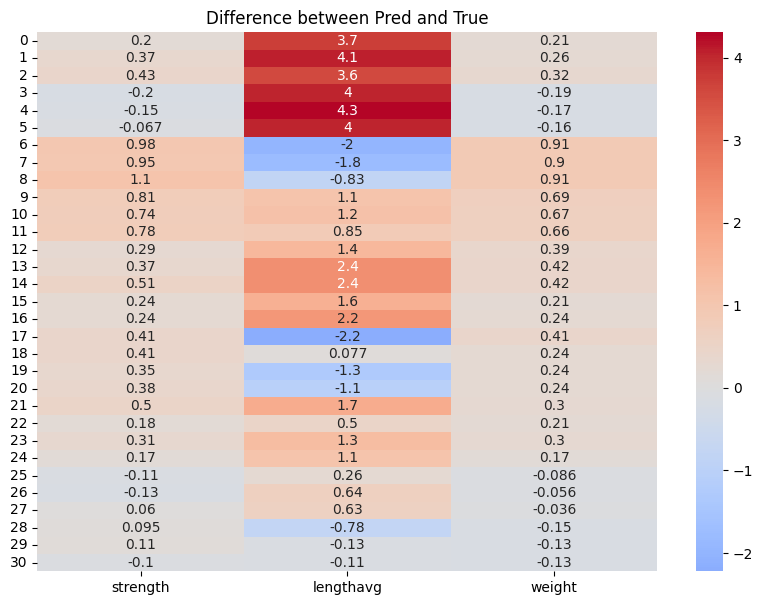

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_difference(pred, true, cols):
    # Shape와 길이 확인
    assert pred.shape == true.shape, "The shape of pred and true arrays should be the same"
    assert len(cols) == pred.shape[1], "Number of columns should match the shape of the arrays"

    # 차이 계산
    diff = np.array(pred) - np.array(true)

    # heatmap으로 차이 표시
    plt.figure(figsize=(10, 7))
    sns.heatmap(diff, annot=True, cmap='coolwarm', center=0, xticklabels=cols)
    plt.title("Difference between Pred and True")
    plt.show()

visualize_difference(test_predictions, test_labels, output_params)

# 단순 오차 계산

In [38]:
def make_martrix(result: pd.DataFrame, names):
    columns = list(result.columns)
    errors={names[0]:0,names[1]:0,names[2]:0}
    for name in names:
        select = [item for item in columns if name in item] # 0 이 예측 1이 실제 
        temp = abs((result[select[1]]-result[select[0]])/result[select[1]])
        errors[name] = temp.mean()*100
    return pd.DataFrame([errors])

data = compare_arrays_with_dataframe(test_predictions, test_labels, output_params)
make_martrix(data, output_params)

,strength,lengthavg,weight
0,37.381283,78.928411,25.893344
